In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
dataset_path = 'UCI HAR Dataset'

# Unzip the dataset
import zipfile
import urllib.request
import os

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, 'UCI_HAR_Dataset.zip')
    with zipfile.ZipFile('UCI_HAR_Dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('.')


In [4]:
# Load the dataset
train_data = pd.read_csv(f'{dataset_path}/train/X_train.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv(f'{dataset_path}/test/X_test.txt', delim_whitespace=True, header=None)
data = pd.concat([train_data, test_data])

# Normalize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# # Apply DBSCAN
# dbscan = DBSCAN(eps=50, min_samples=10)
# clusters = dbscan.fit_predict(data_scaled)

# # Display the original output of DBSCAN
# print("Cluster labels for each point in the dataset:")
# print(clusters)

# unique, counts = np.unique(clusters, return_counts=True)
# cluster_counts = dict(zip(unique, counts))
# print("\nNumber of points in each cluster:")
# print(cluster_counts)

# # Adding the cluster labels to the dataframe
# data['cluster'] = clusters


In [5]:
# Initialize variables to store the best results
best_eps = None
best_min_samples = None
best_clusters = None
best_score = -1
best_labels = None

# Define the grid search ranges for eps and min_samples
eps_values = np.arange(1, 100, 1)
min_samples_values = np.arange(5, 20, 1)

# Function to apply DBSCAN and return the number of clusters
def apply_dbscan(eps, min_samples, data):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data_scaled)
    unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    if unique_clusters > 1:  # We need at least 2 clusters to calculate silhouette score
        score = silhouette_score(data, clusters)
    else:
        score = -1
    return unique_clusters, score, clusters

# Perform the grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        clusters, score, labels = apply_dbscan(eps, min_samples, data_scaled)
        if clusters > 6 and clusters < 8 and score > best_score:  # You can also set a specific cluster count target here
            best_eps = eps
            best_min_samples = min_samples
            best_clusters = clusters
            best_score = score
            best_labels = labels

# Display the best results
print("Best parameters found:")
print(f"eps: {best_eps}, min_samples: {best_min_samples}")
print(f"Number of clusters: {best_clusters}")
print(f"Silhouette Score: {best_score}")

# Display the original output of DBSCAN with the best parameters
print("Cluster labels for each point in the dataset:")
print(best_labels)

unique, counts = np.unique(best_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("\nNumber of points in each cluster:")
print(cluster_counts)

# Adding the cluster labels to the dataframe
data['cluster'] = best_labels

Best parameters found:
eps: 14, min_samples: 13
Number of clusters: 7
Silhouette Score: 0.14412940796471713
Cluster labels for each point in the dataset:
[-1  0  0 ... -1  1  1]

Number of points in each cluster:
{-1: 3255, 0: 5125, 1: 1791, 2: 34, 3: 13, 4: 25, 5: 20, 6: 36}


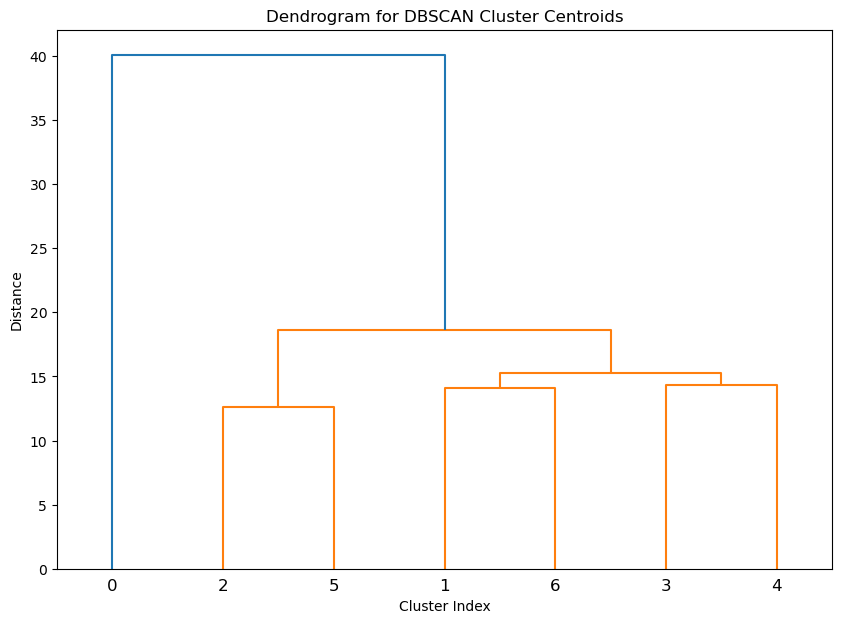

Hierarchical Clustering Labels for DBSCAN centroids: [1 0 2 0 0 2 0]

Hierarchical Cluster labels for each point in the dataset:
0      -1
1       1
2       1
3       1
4       1
       ..
2942    0
2943    0
2944   -1
2945    0
2946    0
Name: hierarchical_cluster, Length: 10299, dtype: int64

Number of points in each hierarchical cluster:
{-1: 3255, 0: 1865, 1: 5125, 2: 54}

Distances between clusters:
Cluster 2 - Cluster 5: 12.609056702383066
Cluster 1 - Cluster 6: 14.13670199048572
Cluster 3 - Cluster 4: 14.350301294617488
Cluster 8 - Cluster 9: 15.246827812597683
Cluster 7 - Cluster 10: 18.651860364303776
Cluster 0 - Cluster 11: 40.048414733609114

Hierarchical Cluster labels for each point in the dataset:
0      -1
1       1
2       1
3       1
4       1
       ..
2942    0
2943    0
2944   -1
2945    0
2946    0
Name: hierarchical_cluster, Length: 10299, dtype: int64

Number of points in each hierarchical cluster:
{-1: 3255, 0: 1865, 1: 5125, 2: 54}


In [6]:
# Calculate centroids of the DBSCAN clusters
centroids = []
for cluster_id in np.unique(best_labels):
    if cluster_id != -1:  # Exclude noise points
        cluster_points = data_scaled[best_labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
centroids = np.array(centroids)

# Generate the linkage matrix for the dendrogram
Z = linkage(centroids, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for DBSCAN Cluster Centroids")
plt.xlabel("Cluster Index")
plt.ylabel("Distance")
plt.show()

# Apply hierarchical clustering on the DBSCAN centroids
n_clusters = 3  # Set the desired number of clusters for hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(centroids)

print("Hierarchical Clustering Labels for DBSCAN centroids:", hierarchical_labels)

# Map hierarchical cluster labels back to original data points
data['hierarchical_cluster'] = -1  # Initialize with -1 (unassigned)
for cluster_id, centroid_label in enumerate(hierarchical_labels):
    data.loc[data['cluster'] == cluster_id, 'hierarchical_cluster'] = centroid_label

# Display the hierarchical cluster labels
print("\nHierarchical Cluster labels for each point in the dataset:")
print(data['hierarchical_cluster'])

unique, counts = np.unique(data['hierarchical_cluster'], return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("\nNumber of points in each hierarchical cluster:")
print(cluster_counts)

# Calculate distances between clusters from the linkage matrix
cluster_distances = {}
for i in range(len(Z)):
    cluster1, cluster2, distance, _ = Z[i]
    cluster_distances[f'Cluster {int(cluster1)} - Cluster {int(cluster2)}'] = distance

print("\nDistances between clusters:")
for pair, distance in cluster_distances.items():
    print(f'{pair}: {distance}')

# Map hierarchical cluster labels back to original data points
data['hierarchical_cluster'] = -1  # Initialize with -1 (unassigned)
for cluster_id, centroid_label in enumerate(hierarchical_labels):
    data.loc[data['cluster'] == cluster_id, 'hierarchical_cluster'] = centroid_label

# Display the hierarchical cluster labels
print("\nHierarchical Cluster labels for each point in the dataset:")
print(data['hierarchical_cluster'])

unique, counts = np.unique(data['hierarchical_cluster'], return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("\nNumber of points in each hierarchical cluster:")
print(cluster_counts)
